<h2 style="color:blue" align="center"> Capstone Project Semantic Segmentation


---


**Name - Kummathi Yeshwanth Reddy**

**October 25, 2022**


---
</h2>

## **Problem Statement**

**Semantic segmentation**


Create a semantic segmentation model using Tensorflow that determines the region of the disease looking at the 3D medical image provided. Only task to be done is colon cancer segmentation.

Utilize Transfer learning to train the model faster

Train and validate the model on 2D images (converted from 3D)

Demonstrate by inferencing on both 2D images and 3D images.

Keep the latency of the model (forward pass) less than 250ms on the GPU provided on Colab (Nvidia T4)


**Dataset**  http://medicaldecathlon.com/

#Dataset Features

The dataset consists of three folders:



*   **Train images** - 126 files
*   **Train labels** - 126 files
*   **Test images** - 64 files





   

The data in in **.nii.gz** extension.

The data format is **NIFTI** (Neuroimaging Informatics Technology Initiative) which is used for the storage of Functional Magnetic Resonance Imaging (fMRI) and other medical images.

NIfTI images are registered in a local coordinate system.

It is a 3-dimensional (3D) array : where individual slices are stacked on top of each other.

#Packages to read and visualize the dataset

##**NiBabel library**



As I am working with NIfTI files and to be able to read these files in python I will be using the **NiBabel library**. NiBabel is a python library to read and write some common medical and neuroimaging file formats such as NIfTI files.

##**Niwidgets Package**

**Niwidgets** is a package that provides easy and general wrappers to display interactive widgets that visualise standard-format neuroimaging data, using new functions and standard functions from other libraries.

# Importing libraries

In [ ]:
# Installing Nibabel package for Read / write access to some common neuroimaging file formats.
!pip install nibabel==2.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 37.4 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
!pip install scikit-learn==0.20.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 35.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.3 which is incompatible.


In [ ]:
# Installing niwidgets package for interactive neuroimaging plots.
!pip install niwidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.5 MB 3.4 MB/s 
     |████████████████████████████████| 2.9 MB 37.2 MB/s 
     |████████████████████████████████| 2.3 MB 42.3 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 260 kB 10.2 MB/s 
     |████████████████████████████████| 1.6 MB 56.8 MB/s 
     |████████████████████████████████| 271 kB 52.0 MB/s 


In [ ]:
from niwidgets import NiftiWidget
import nibabel as nib

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import os,time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from glob import glob
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Downloading the Dataset

## Mounting the drive containing the dataset

In [ ]:
# Mounting drive where the data is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **The dataset is in tar format**

##Extracting tar file

In [ ]:
# Import module
import tarfile

with tarfile.open("/content/drive/MyDrive/Task10_Colon.tar","r") as tr:
    print("Opened tarfile")
    tr.extractall(path="./content/drive/MyDrive/project") # Extraction of tar file
    print("All files extracted")

Opened tarfile
All files extracted


# Dataset visualization

**Raw extracted dataset visualization using Pandas**

In [ ]:
# File path
image_path = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr'
masks_path = '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr'


In [ ]:
# Function to create list of filenames of files in the directory

def file_name(path):
  files = []
  for f in os.listdir(path):
    files.append(f)
  return files

In [ ]:
images = file_name(image_path)
masks = file_name(masks_path)

In [ ]:
# Checking the length
len(images), len(masks)

(252, 252)

## Converting the images and masks to dataframe

In [ ]:
# Created dataframe using pandas
imagemask_df = pd.DataFrame({'images':images,'masks':masks})
imagemask_df.head()

,images,masks
0,._colon_038.nii.gz,._colon_038.nii.gz
1,._colon_045.nii.gz,._colon_045.nii.gz
2,colon_176.nii.gz,colon_176.nii.gz
3,colon_218.nii.gz,colon_218.nii.gz
4,colon_192.nii.gz,colon_192.nii.gz


In [ ]:
imagemask_df['images'][0]

'._colon_038.nii.gz'

In [ ]:
# Using the Nibabel package for loading the .nii format images
imgTargetNii = nib.load("/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz")
imgMaskNii  = nib.load("/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz")


##3d data visualization

**Interactive 3D Image Visualization using niwidgets package**

In [ ]:
# Visualizing the 3D training image
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

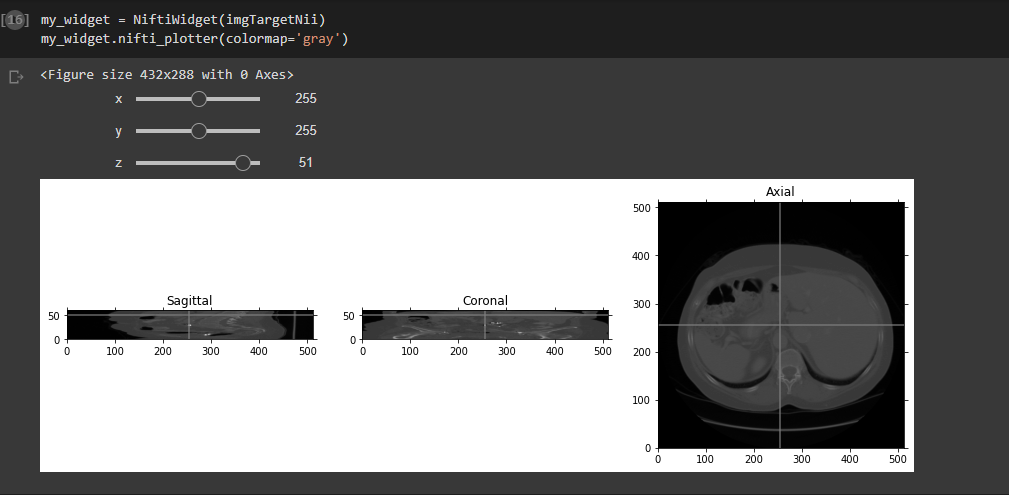

In [ ]:
# Displaying an image from a file using display module of Interactive Python(Ipython) API.

from IPython.display import Image
Image(filename='imgTargetNii.PNG')

In [ ]:
# Visualizing the 3D training mask
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

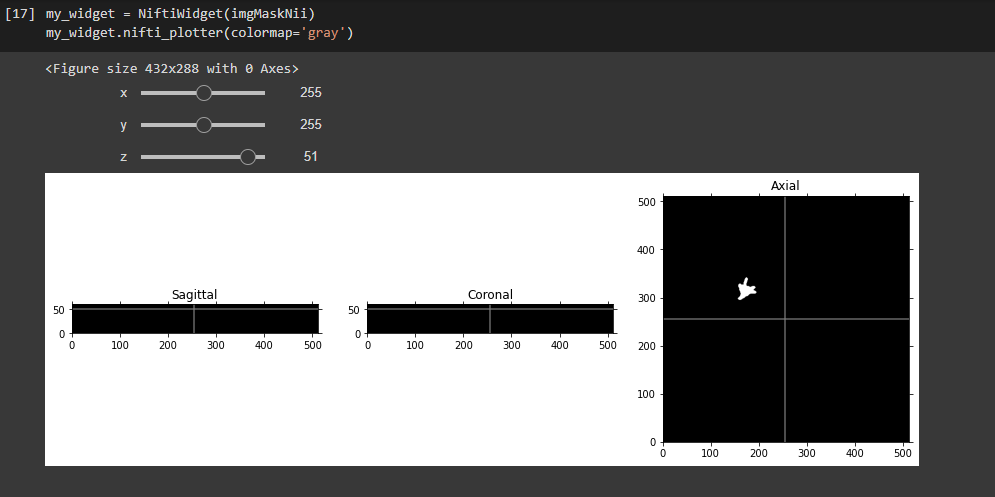

In [ ]:
# Displaying an image from a file using display module of Interactive Python(Ipython) API.
from IPython.display import Image
Image(filename='imgMaskNii.PNG')

## Normalizing the *data*

In [ ]:
# Importing required dependencies
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(image_path, '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1024.0, 3072.0, (512, 512, 60), numpy.ndarray)

In [ ]:

# Load image mask and see max min Hounsfield units
maskPath = os.path.join(masks_path, '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

In [ ]:
# Image normalization
HOUNSFIELD_MIN = -1024
HOUNSFIELD_MAX = 3072
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

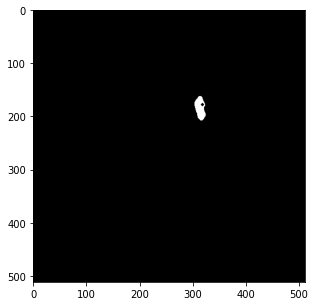

In [ ]:
# Show image slice
imgSlice = mask[:,:,52]
plt.figure(figsize = (30,5))
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [ ]:
# Define a function for Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

In [ ]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=True)

array([[[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       ...,

       [[0.25, 0.25, 0.2

**Since the data is in 3d,we are converting it to 2d by extracting each slice from it and saving it**

## Data slicing

In [ ]:
# Making directory to store the slices

!mkdir /content/imageslice /content/maskslice /content/testimageslice /content/temp

# Define slice output paths

imageSliceOutput = '/content/imageslice/'
maskSliceOutput = '/content/maskslice/'
test_imageSliceOutput = '/content/testimageslice/'

In [ ]:
# Function to save the slices img

def saveImageSlice(image, filename, path, mul=True):
  if mul:
    img = np.uint8(image * 255)
  else:
    img = np.uint8(image)
  fout = os.path.join(path, f'{filename}.png')
  cv2.imwrite(fout, img)
  print(f'[+] Slice saved: {fout}', end='\r')

In [ ]:
# Slice image in z direction and save

def sliceAndSaveVolumeImage(vol, filename, path, mul=True):
  (dimx, dimy, dimz) = vol.shape
  print(dimx, dimy, dimz)
  cnt = 0
  cnt += dimz
  for i in range(dimz):
      saveImageSlice(vol[:,:,i], filename+f'-slice{str(i).zfill(3)}', path, mul)
  return cnt

###  Slicing on Training Image Data

In [ ]:
# Read and process image volumes

imagePathInput = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr'

# Running a loop for every data in Train dataset to create 2d image slices
# Using glob module to retrieve files/pathnames matching a specified pattern of dataset(colon_001.nii.gz)
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/*.nii.gz'))):

    # Loading the data and normalizing it
    img = readImageVolume(filename, True)

    # Printing the data name,shape,minimum and maximum values
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))

    # Slicing the data along the 2nd index and saving the image slice in imageSliceOutput folder
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), imageSliceOutput)

    # Printing the sliced train image filename and total slices created
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
[+] Slice saved: /content/imageslice/colon0-slice059.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz, 60 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_005.nii.gz (512, 512, 98) 1122 0.0 0.59521484375
512 512 98
[+] Slice saved: /content/imageslice/colon1-slice097.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_005.nii.gz, 98 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_006.nii.gz (512, 512, 68) 1092 0.0 0.601318359375
512 512 68
[+] Slice saved: /content/imageslice/colon2-slice067.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_006.nii.gz, 68 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_007.nii.gz (512, 512, 74) 1098 0.0 0.528564453125
512 512 74
[+] Slice saved: /content/images

###  Slicing On Training Masks Images Data

In [ ]:
# Read and process image mask volumes

maskPathInput = '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr'

# Running a loop for every data in Mask dataset to create 2d image slices
# Using glob module to retrieve files/pathnames matching a specified pattern of dataset(colon_001.nii.gz)
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/*.nii.gz'))):

    # Loading the data and not Normalizing it since it has label data
    img = readImageVolume(filename, False)

    # Printing the data name,shape,minimum and maximum values
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))

    # Slicing the data along the 2nd index and saving the image slice in maskSliceOutput folder
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), maskSliceOutput)

    # Printing the sliced mask filename and total slices created
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
[+] Slice saved: /content/maskslice/colon0-slice059.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz, 60 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_005.nii.gz (512, 512, 98) 1122 0.0 1.0
512 512 98
[+] Slice saved: /content/maskslice/colon1-slice097.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_005.nii.gz, 98 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_006.nii.gz (512, 512, 68) 1092 0.0 1.0
512 512 68
[+] Slice saved: /content/maskslice/colon2-slice067.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_006.nii.gz, 68 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_007.nii.gz (512, 512, 74) 1098 0.0 1.0
512 512 74
[+] Slice saved: /content/maskslice/colon3-slice073.png
/content/co

###  Slicing On Test Images Data

In [ ]:
# Read and process image volumes

imagePathInput = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTs'

# Running a loop for every data in Mask dataset to create 2d image slices
# Using glob module to retrieve files/pathnames matching a specified pattern of dataset(colon_001.nii.gz)
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/*.nii.gz'))):

    # Loading the data and normalizing it
    img = readImageVolume(filename, True)

    # Printing the data name,shape,minimum and maximum values
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))

    # Slicing the data along the 2nd index and saving the image slice in test_imageSliceOutput folder
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), test_imageSliceOutput)

    # Printing the sliced test image filename and total slices created
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_003.nii.gz (512, 512, 127) 1151 0.0 0.999755859375
512 512 127
[+] Slice saved: /content/testimageslice/colon0-slice126.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_003.nii.gz, 127 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_004.nii.gz (512, 512, 185) 1209 0.005859375 1.0
512 512 185
[+] Slice saved: /content/testimageslice/colon1-slice184.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_004.nii.gz, 185 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_010.nii.gz (512, 512, 64) 1088 0.0 0.5859375
512 512 64
[+] Slice saved: /content/testimageslice/colon2-slice063.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_010.nii.gz, 64 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_013.nii.gz (512, 512, 92) 1116 0.005859375 0.66552734375
512 512 92
[+]

## Converting the sliced images and mask to dataframe

In [ ]:
# Define sliced images path
image_slicepath = '/content/imageslice'
masks_slicepath = '/content/maskslice'
test_imageSliceOutput = '/content/testimageslice/'

In [ ]:
# Function to create list of filenames of files in the directory

def file_name(path):
  files = []
  for f in os.listdir(path):
    files.append(f)
  return files

In [ ]:
slice_images = file_name(image_slicepath)
slice_masks = file_name(masks_slicepath)
slice_test_images = file_name(test_imageSliceOutput)


In [ ]:
# Length of list or number of slices in each list
len(slice_images), len(slice_masks) , len(slice_test_images)

(13486, 13486, 6616)

In [ ]:
# Creating a dataframe of sliced images and sliced masks
imagemask_df = pd.DataFrame({'slice_images':slice_images,'slice_masks':slice_masks})
imagemask_df.head()

,slice_images,slice_masks
0,colon84-slice054.png,colon84-slice054.png
1,colon88-slice075.png,colon88-slice075.png
2,colon45-slice026.png,colon45-slice026.png
3,colon118-slice346.png,colon118-slice346.png
4,colon23-slice023.png,colon23-slice023.png


In [ ]:
imagemask_df['slice_images'][0]

'colon84-slice054.png'

In [ ]:
# Creating dataframe of sliced test images
test_image_df = pd.DataFrame({'slice_test_images':slice_test_images})
test_image_df.head()

,slice_test_images
0,colon11-slice155.png
1,colon45-slice026.png
2,colon23-slice023.png
3,colon26-slice063.png
4,colon39-slice049.png


Now ,the image format is sliced and converted from .nii.gz to .png file and saved in the path provided

## Sliced data visualization of images and Masks

In [ ]:
# Shape of Images and masks

def print_imShape(df, image_path, masks_path):
  idx = random.randint(0,len(slice_images))
  image = cv2.imread(image_slicepath +'/'+ df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ df['slice_masks'][idx])

  print("Image shape:",image.shape)
  print("Mask shape:",mask.shape)

In [ ]:
for i in range(5):
  print_imShape(imagemask_df, image_slicepath, masks_slicepath)

Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)


**Visualizing the sliced data using matplotlib and cv2**

In [ ]:
# Defining the function for plotting the sliced images and masks

def plot_images(df, image_path, masks_path):

  idx = random.randint(0,len(imagemask_df))

  image = cv2.imread(image_slicepath +'/'+ df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ df['slice_masks'][idx])

  fig, axs = plt.subplots(1,3, figsize=[13,15])

  axs[0].imshow(image)
  axs[0].set_title("Colon Cancer Slice")

  plt.grid(False)

  axs[1].imshow(mask)
  axs[1].set_title('Mask')

  plt.grid(False)

  axs[2].imshow(image)
  axs[2].imshow(mask, alpha=0.3)
  axs[2].set_title('Cancer with mask')

  plt.grid(False)
  plt.show()


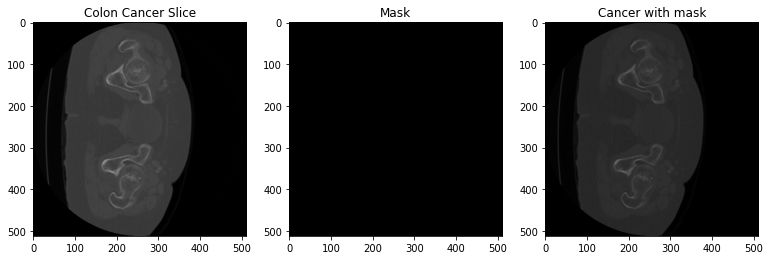

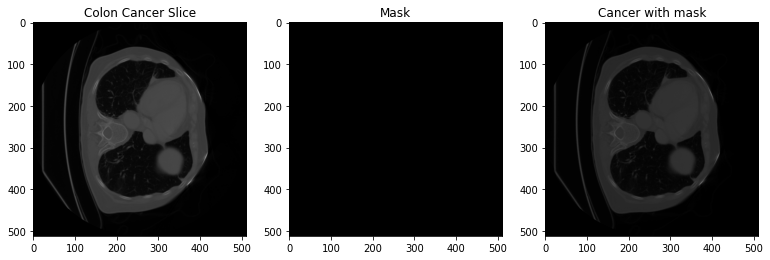

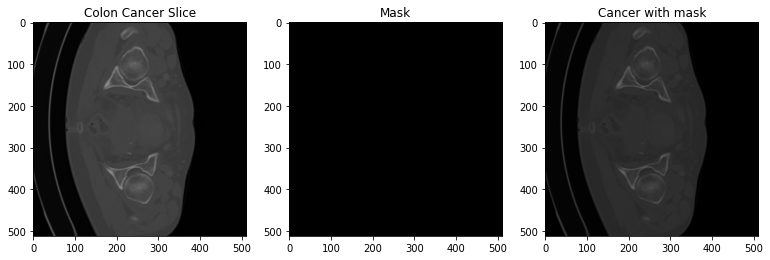

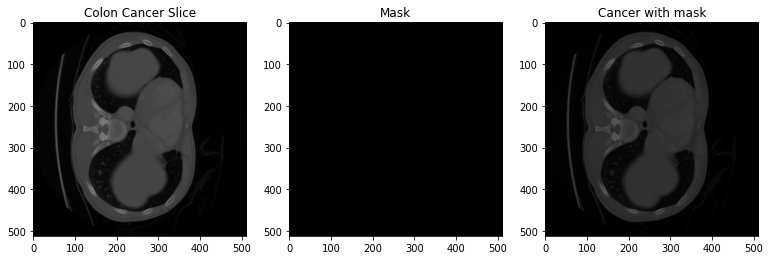

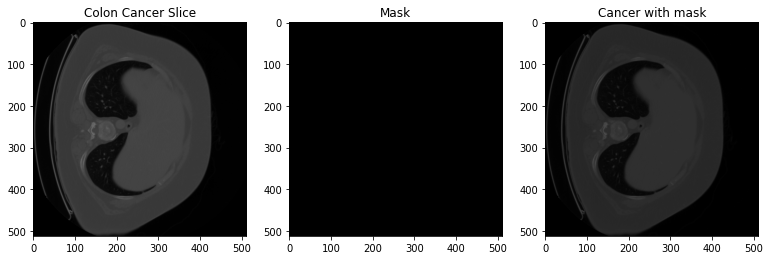

In [ ]:
for i in range(5):
  plot_images(imagemask_df, image_slicepath, masks_slicepath)

In [ ]:
# Creating dataframe of images and its corresponding masks

imgMask_path = pd.DataFrame({'image-path':image_slicepath+'/'+ imagemask_df['slice_images'],
                             'mask-path':masks_slicepath+'/'+ imagemask_df['slice_masks']})
imgMask_path.head()

,image-path,mask-path
0,/content/imageslice/colon84-slice054.png,/content/maskslice/colon84-slice054.png
1,/content/imageslice/colon88-slice075.png,/content/maskslice/colon88-slice075.png
2,/content/imageslice/colon45-slice026.png,/content/maskslice/colon45-slice026.png
3,/content/imageslice/colon118-slice346.png,/content/maskslice/colon118-slice346.png
4,/content/imageslice/colon23-slice023.png,/content/maskslice/colon23-slice023.png


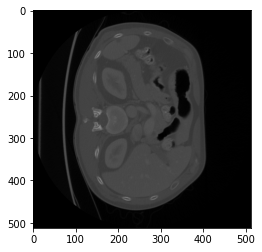

In [ ]:
# Plotting image from sliced training image
plt.imshow(cv2.imread(imgMask_path['image-path'][12]))

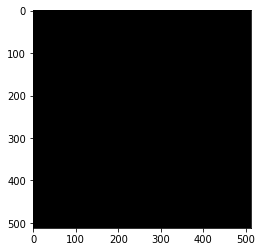

In [ ]:
# Plotting it's corresponding sliced mask
plt.imshow(cv2.imread(imgMask_path['mask-path'][12]))

# Data augmentation and preprocess

In [ ]:
# Train and test data split using sklearn
train, test = train_test_split(imgMask_path,test_size=0.20, random_state=21)

In [ ]:
# Number of images in traning and test data
len(train), len(test)

(10788, 2698)

## Data augmentation

In [ ]:
# Defining the hyperparameters

EPOCHS = 30
BATCH_SIZE = 64
ImgHeight = 256
ImgWidth = 256
Channels = 3

In [ ]:
# Define data augmentation arguments

data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

## Dataset into Train and Validation data

**Training Images and Masks data generation Using ImageDataGenerator.**

In [ ]:
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# Train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# Mask train generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')

Found 10788 validated image filenames.
Found 10788 validated image filenames.


**Validation Images and Validation Masks Generation Using ImageDataGenerator.**

In [ ]:
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

# Validation images generator
vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
                                             x_col = "image-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='rgb')
# Validation masks generator
vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
                                             x_col = "mask-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='grayscale')

Found 2698 validated image filenames.
Found 2698 validated image filenames.


In [ ]:
def data_iterator(image_gen,mask_gen):
  for img, mask in zip(image_gen,mask_gen):
      yield img, mask

In [ ]:
train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(vimage_generator,vmask_generator)

# Defining different metrics

**We will check our model on different metrics to evaluate its performance better**

**To evaluate how our model is doing on a semantic segmentation task we can use the IOU , Dice Coefficent**

## IOU

 **IoU** is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth

<h2 style="color:blue" align="center">

**IOU**

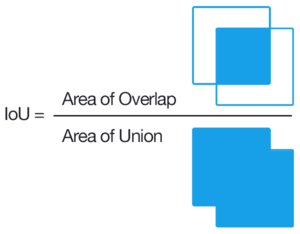

## Dice Coefficient



The **Dice Coefficient** is 2 * the Area of Overlap (between predicted masked area and true masked area) divided by the total number of pixels in both images.

<h2 style="color:blue" align="center">

**Dice Coefficient**

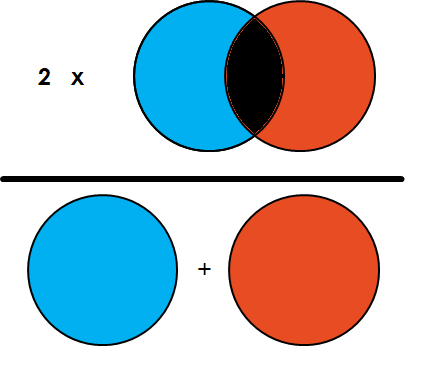

In [ ]:
def iou(ytrue, ypred):

    # Introduce a smoothening value to prevent division by zero error.
    smoothing_factor=0.1

    # Calculating the single scalar absolute value product of y_true and y_pred as the intersection
    intersection = K.sum(ytrue*ypred)

    # Calculating the scalar value of region including y_true and y_pred but not the intersecting area as the union
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection

    # Calculate IoU by dividing Intersection and Union
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
   # Flatten
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    return -iou(y_true, y_pred)

# Dice Sorenson
def dice_coef(ytrue, ypred):
    # Introduce a smoothening value to prevent division by zero error.
    smoothing_factor=0.1

    # Flatten
    ytrue_f = K.flatten(ytrue)
    ypred_f = K.flatten(ypred)

    # Calculating the single scalar absolute value product of y_true and y_pred as the intersection
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    combined_area = ytrue_area + ypred_area

    # Calculate Dice
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

# Model making - Utilizing Transfer learning to train the model faster

## Importing the pretrained segmentation model library

In [ ]:
# Installing the segmentation models
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.7 MB/s 


## Using Resnet50 Model

In [ ]:
# Importing Required Libraries

import imageio
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
# Creating List of Images

image_list = os.listdir(image_slicepath)
mask_list = os.listdir(masks_slicepath)

image_list = [image_slicepath+i for i in image_list]
mask_list = [masks_slicepath+i for i in mask_list]

In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# Creating tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/imageslicecolon84-slice054.png', shape=(), dtype=string)
tf.Tensor(b'/content/maskslicecolon84-slice054.png', shape=(), dtype=string)


In [ ]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=13486>

### Importing the model

In [ ]:
# Taking the model
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Compiling the model

In [ ]:
# Compiling the model
model_2 = sm.Unet(BACKBONE, encoder_weights='imagenet') #weights were assigned using imagenet
model_2.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])
print(model_2.summary())

94592056/94592056 [==============================] - 15s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

In [ ]:
my_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])

### Model Training

In [ ]:
# Defining callbacks and ReduceLR

callbacks_2 = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-6, verbose=1),
    # Model is saved in the path given above
    ModelCheckpoint('/content/model2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
# Model training
resnet_results = my_model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    callbacks=callbacks_2,
                    validation_data=val_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/10
169/168 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9996 - iou: 0.2729 - dice_coef: 0.4115 - precision: 0.7684
Epoch 1: val_loss improved from inf to 0.00978, saving model to /content/model2.h5
168/168 [==============================] - 366s 2s/step - loss: 0.0011 - accuracy: 0.9996 - iou: 0.2729 - dice_coef: 0.4115 - precision: 0.7684 - val_loss: 0.0098 - val_accuracy: 0.9995 - val_iou: 9.1085e-05 - val_dice_coef: 1.8216e-04 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
169/168 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9996 - iou: 0.2957 - dice_coef: 0.4439 - precision: 0.7937
Epoch 2: val_loss improved from 0.00978 to 0.00270, saving model to /content/model2.h5
168/168 [==============================] - 301s 2s/step - loss: 0.0010 - accuracy: 0.9996 - iou: 0.2957 - dice_coef: 0.4439 - precision: 0.7937 - val_loss: 0.0027 - val_accuracy: 0.9995 - val_iou: 0.0596 - val_dice_coef: 0.1088 - val_precision: 0.4312 -

###Saving and Loading the model

In [ ]:
my_model.save("model7")


In [ ]:
!cp /content/drive/MyDrive/model.zip /content

In [ ]:
!cp model7.zip /content/drive/MyDrive

In [ ]:
!unzip "/content/drive/MyDrive/model6.zip"

Archive:  /content/drive/MyDrive/model6.zip
   creating: content/model6/
   creating: content/model6/assets/
  inflating: content/model6/keras_metadata.pb  
  inflating: content/model6/saved_model.pb  
   creating: content/model6/variables/
  inflating: content/model6/variables/variables.index  
  inflating: content/model6/variables/variables.data-00000-of-00001  


In [ ]:
!zip -r model7.zip /content/model7

  adding: content/model7/ (stored 0%)
  adding: content/model7/assets/ (stored 0%)
  adding: content/model7/keras_metadata.pb (deflated 96%)
  adding: content/model7/saved_model.pb (deflated 92%)
  adding: content/model7/variables/ (stored 0%)
  adding: content/model7/variables/variables.index (deflated 80%)
  adding: content/model7/variables/variables.data-00000-of-00001 (deflated 13%)


In [ ]:
my_model = load_model("/content/content/model6",custom_objects={'iou':iou,'dice_coef':dice_coef})

#Visualizing Model Performance

## Epochs vs Different metrics

In [ ]:
def show_graph_resnet(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  dice_train = history.history['dice_coef']
  dice_val = history.history['val_dice_coef']
  iou_train = history.history['iou']
  iou_val = history.history['val_iou']
  precision_train = history.history['precision']
  precision_val = history.history['val_precision']
  epochs = range(len(loss_train))


  plt.figure(figsize=(18,12))
  plt.subplot(2,2,1)
  plt.plot(epochs, loss_train, 'r', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2,2,2)
  plt.plot(epochs, dice_train, 'r', label='Training Dice')
  plt.plot(epochs, dice_val, 'b', label='validation Dice')
  plt.title('Training and Validation Dice Co-efficient')
  plt.xlabel('Epochs')
  plt.ylabel('Dice Co-efficient')
  plt.legend()

  plt.subplot(2,2,3)
  plt.plot(epochs, iou_train, 'r', label='Training IOU')
  plt.plot(epochs, iou_val, 'b', label='validation IOU')
  plt.title('Training and Validation IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()

  plt.subplot(2,2,4)
  plt.plot(epochs, precision_train, 'r', label='Training Precision')
  plt.plot(epochs, precision_val, 'b', label='validation Precision')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

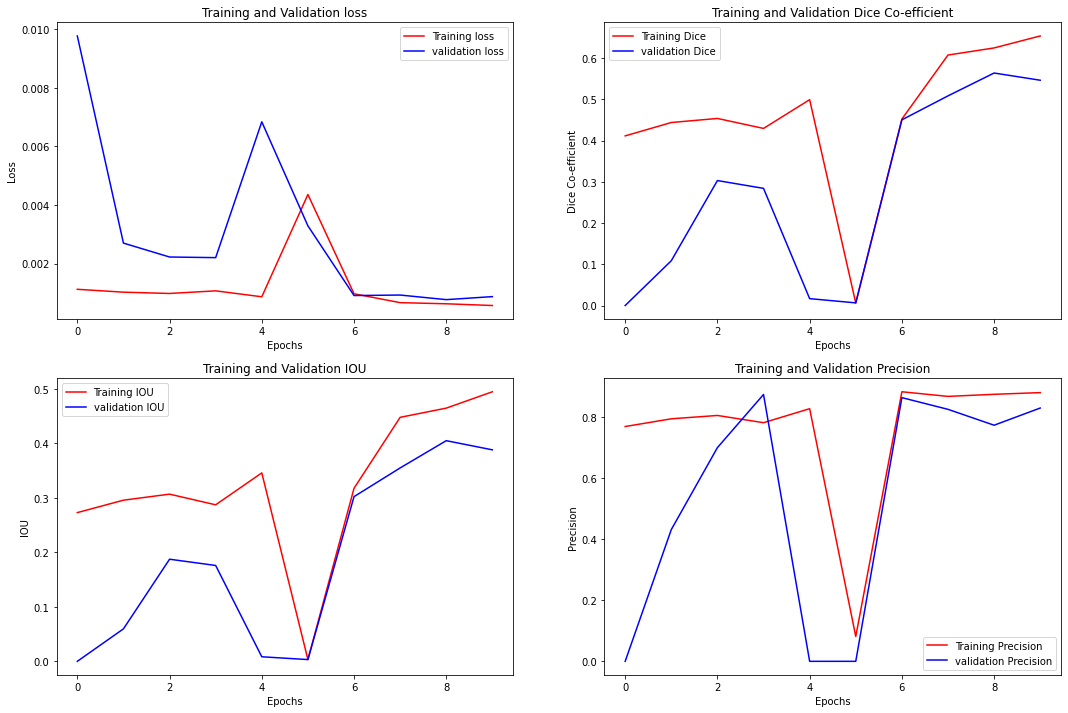

In [ ]:
show_graph_resnet(resnet_results)

# Model prediction on 2d data

## Validation data

**Validation Data is the data that, we've generated using tf ImageDataGenerator.**

1/1 [==============================] - 0s 77ms/step
The latency of the prediction is 204.62608337402344ms



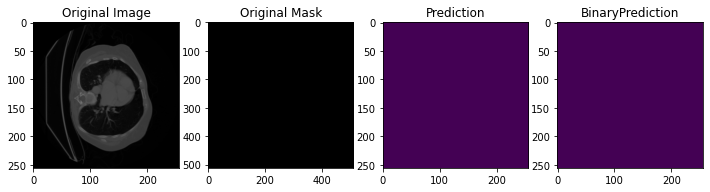


Similarity between two images is 0.9999998391819024
#########################################

1/1 [==============================] - 0s 66ms/step
The latency of the prediction is 221.3430404663086ms



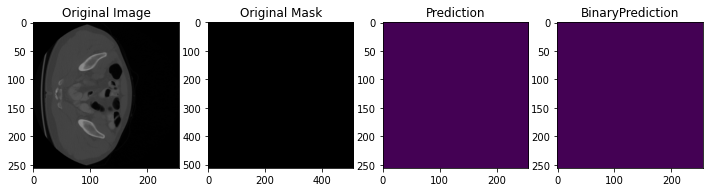


Similarity between two images is 0.9995282885682266
#########################################

1/1 [==============================] - 0s 46ms/step
The latency of the prediction is 119.48704719543457ms



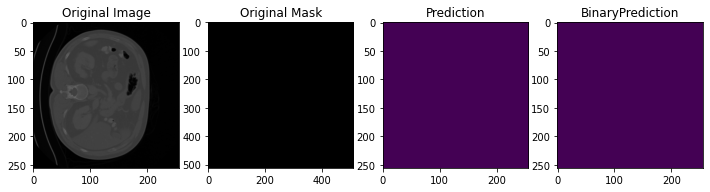


Similarity between two images is 0.9999976827906373
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 111.01651191711426ms



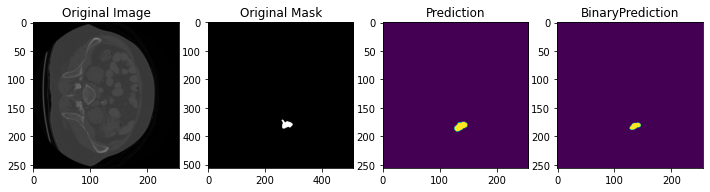


Similarity between two images is 0.9862194375861336
#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 81.59112930297852ms



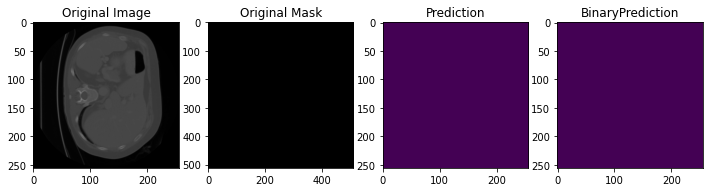


Similarity between two images is 0.9999998417924121
#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 112.81442642211914ms



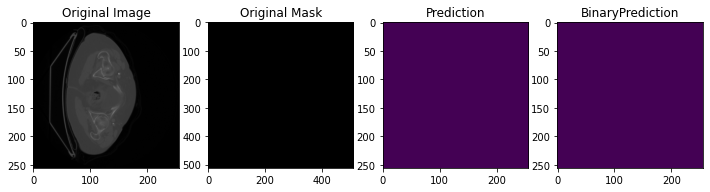


Similarity between two images is 0.9999774907920579
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 71.96331024169922ms



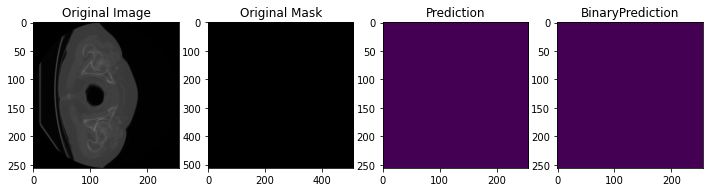


Similarity between two images is 0.9999997081417413
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 72.74985313415527ms



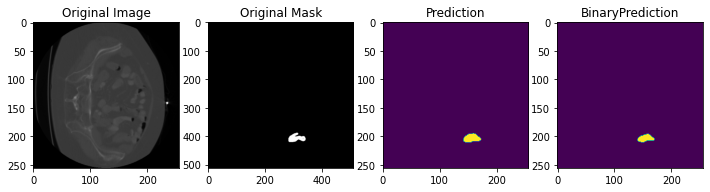


Similarity between two images is 0.9875650102825073
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 108.83784294128418ms



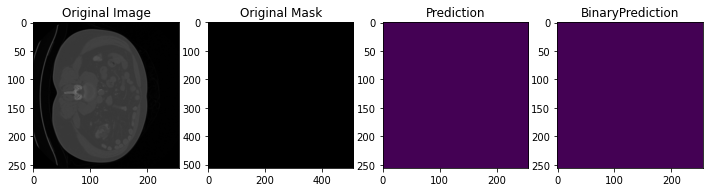


Similarity between two images is 0.9998410035684399
#########################################

1/1 [==============================] - 0s 27ms/step
The latency of the prediction is 80.91950416564941ms



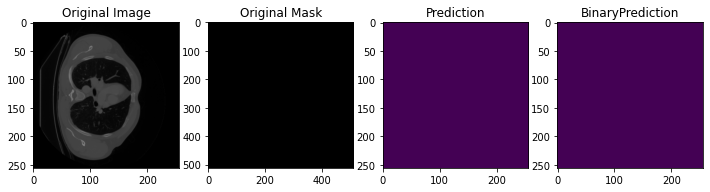


Similarity between two images is 0.9999820157289808
#########################################



In [ ]:
for i in range(10):

  # Choose a random image data within the Validation_dataframe
  idx = random.randint(0,len(imagemask_df))

  # Reading the data
  image = cv2.imread(image_slicepath +'/'+ imagemask_df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ imagemask_df['slice_masks'][idx])

  # Resizing and normalizing
  img = cv2.resize(image,(ImgHeight,ImgWidth))
  msk = cv2.resize(mask,(ImgHeight,ImgWidth))
  img_gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
  img = img/255

  # Dimension expansion
  img = img[np.newaxis,:,:,:]

  # Predicting the output and calculating its latency using python time module
  start_time=time.time()
  pred=my_model.predict(img)
  print("The latency of the prediction is " + str((time.time()-start_time)*1000)+"ms\n")
  k = np.squeeze(pred) # Remove the batch dimension

  # Plotting the input and original label vs Prediction label
  plt.figure(figsize=(12,12))
  plt.subplot(1,4,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,4,2)
  plt.imshow(mask)
  plt.title('Original Mask')
  plt.subplot(1,4,3)
  plt.imshow(np.squeeze(pred) > 0.3)
  plt.title('Prediction')
  plt.subplot(1,4,4)
  plt.imshow(np.squeeze(pred) > 0.5)
  plt.title('BinaryPrediction')
  plt.show()
  print("\nSimilarity between two images is " + str(ssim(k,img_gray)))
  print("#########################################\n")

## Test data

**Test Data is the data, that we got in the .tar file for Inference.**

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 112.22958564758301ms



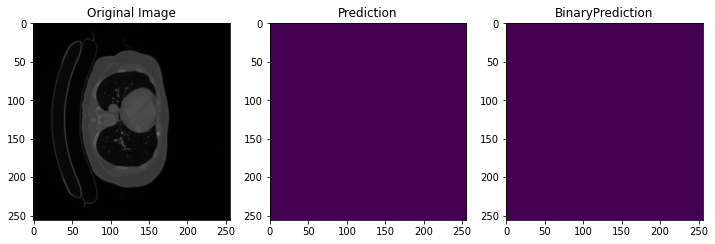


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 109.17258262634277ms



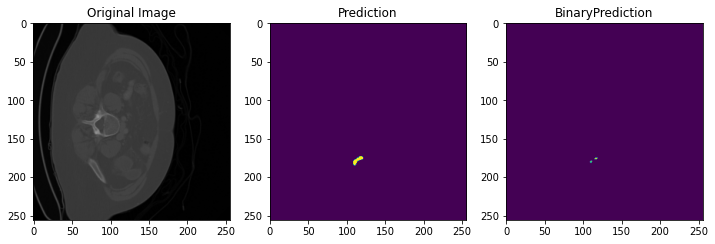


#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 76.23982429504395ms



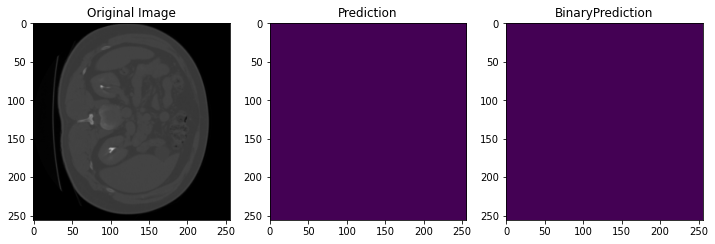


#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 110.00585556030273ms



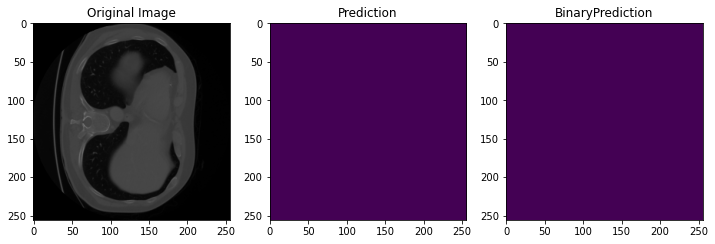


#########################################

1/1 [==============================] - 0s 31ms/step
The latency of the prediction is 77.8651237487793ms



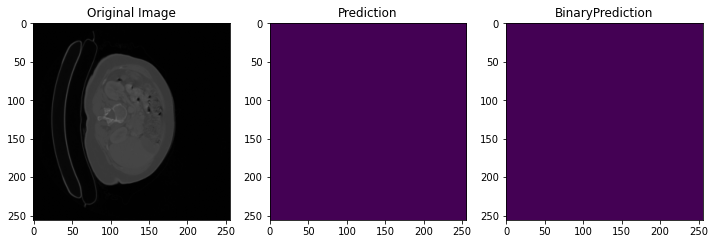


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 73.98295402526855ms



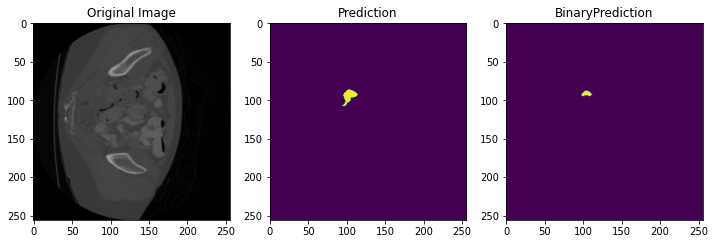


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 77.60238647460938ms



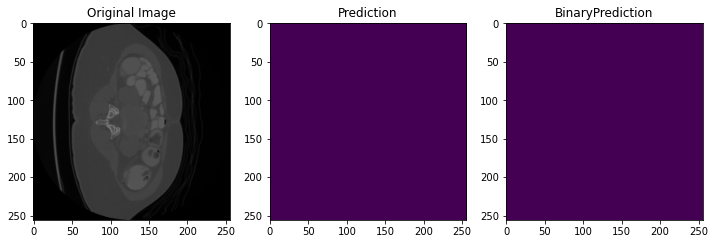


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 71.56515121459961ms



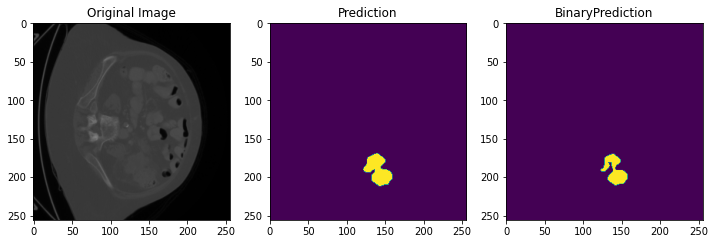


#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 78.98092269897461ms



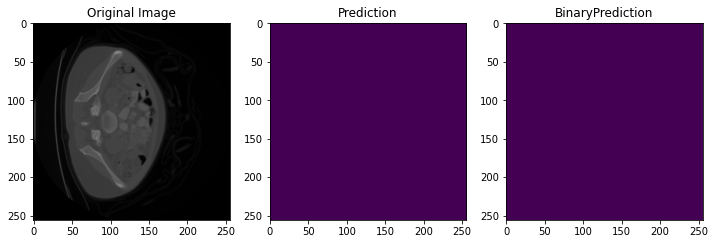


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 116.54496192932129ms



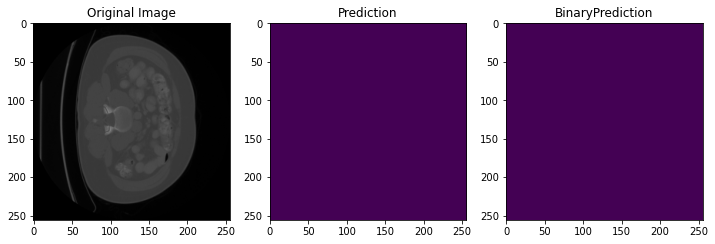


#########################################



In [ ]:
for i in range(10):

  # Choose a random image data within the Validation_dataframe
  idx = random.randint(0,len(test_image_df))

  # Reading the data
  image = cv2.imread(test_imageSliceOutput +'/'+ test_image_df['slice_test_images'][idx])
  #mask = cv2.imread(masks_slicepath +'/'+ imagemask_df['slice_masks'][idx])

  # Resizing and normalizing
  img = cv2.resize(image,(ImgHeight,ImgWidth))
  #msk = cv2.resize(mask,(ImgHeight,ImgWidth))
  #img_gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
  img = img/255

  # Dimension expansion
  img = img[np.newaxis,:,:,:]

  # Predicting the output and calculating its latency using python time module
  start_time=time.time()
  pred=my_model.predict(img)
  print("The latency of the prediction is " + str((time.time()-start_time)*1000)+"ms\n")
  k = np.squeeze(pred) # Remove the batch dimension

  # Plotting the input and original label vs Prediction label
  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(pred) > 0.3)
  plt.title('Prediction')
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred) > 0.5)
  plt.title('BinaryPrediction')
  plt.show()
  print("\n#########################################\n")

# Prediction on 3d data

## Preprocessing the input

In [ ]:
# Preprocessing the 3D input data
trimage_3d = "/content/content/drive/MyDrive/project/Task10_Colon/imagesTr"
trmask_3d = "/content/content/drive/MyDrive/project/Task10_Colon/labelsTr"
tsimage_3d = "/content/content/drive/MyDrive/project/Task10_Colon/imagesTs"

In [ ]:
# Creating list of filenames of files in the directory

def fil_name(path):
  files = []
  for f in os.listdir(path):
    if f.startswith('colon_'):
        files.append(f)
  return files

In [ ]:
trimages = fil_name(trimage_3d)
trmasks = fil_name(trmask_3d)
tsimages = fil_name(tsimage_3d)


In [ ]:
# number of 3d images in training, masks, and test list
len(trimages),len(trmasks),len(tsimages)

(126, 126, 64)

##Converting the test images to dataframe

In [ ]:
# Creating dataframe of training images
tr_image3d_df = pd.DataFrame({'tr_images':trimages})
tr_image3d_df.head()

,tr_images
0,colon_176.nii.gz
1,colon_218.nii.gz
2,colon_192.nii.gz
3,colon_196.nii.gz
4,colon_145.nii.gz


In [ ]:
# Creating dataframe of masks or labels
tr_mask3d_df = pd.DataFrame({'tr_masks':trmasks})
tr_mask3d_df.head()

,tr_masks
0,colon_176.nii.gz
1,colon_218.nii.gz
2,colon_192.nii.gz
3,colon_196.nii.gz
4,colon_145.nii.gz


In [ ]:
# Creating dataframe of test images
ts_image3d_df = pd.DataFrame({'ts_images':tsimages})
ts_image3d_df.head()

,ts_images
0,colon_182.nii.gz
1,colon_060.nii.gz
2,colon_121.nii.gz
3,colon_004.nii.gz
4,colon_110.nii.gz


## Custom function for predicting every layer in 3d data

In [ ]:
# Define a function for predicting 3D data
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape

    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))

    # Creating a list to store latency time
    r_time = []
    cnt = 0.0

    # Slicing the image along the 2nd index or z-dimension
    if SLICE_Z:
        cnt += 1.0
        # Running the loop along the z dimension
        for i in range(zMax):
            # Reading the image slice
            img = np.uint8(inImg[:,:,i] * 255)
            # Saving the slice and reading it
            fout = os.path.join("/content/temp",'temp.png')
            cv2.imwrite(fout,img)
            img = cv2.imread("/content/temp/temp.png")
            # Normalizing it
            img = img/255

            # Dimension expansion
            img = img[np.newaxis,:,:]

            # Predicting the output and calculating its latency using python time module
            start_time = time.time()
            pred = my_model.predict(img)
            end_time = time.time()
            r_time.append(end_time-start_time)
            k = np.squeeze(pred) # Remove the batch dimension
            outImgZ[:,:,i] = cv2.resize(k,(xMax,yMax))

    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    print("The latency of the predictions is :"+ str(np.mean(r_time)*1000)+"ms")
    return outImg

In [ ]:
idx = random.randint(0,len(tr_image3d_df))
imgPath = trimage_3d +'/'+ tr_image3d_df ['tr_images'][idx]
imgTarget = readImageVolume(imgPath, normalize=True)

In [ ]:
predImg = predictVolume(imgTarget)

1/1 [==============================] - 0s 28ms/step
The latency of the predictions is :103.50437597794966ms


In [ ]:
#idx = random.randint(0,len(tr_mask3d_df))
mskPath = trmask_3d +'/'+ tr_mask3d_df ['tr_masks'][idx]
imgMaskNii = nib.load(mskPath)
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

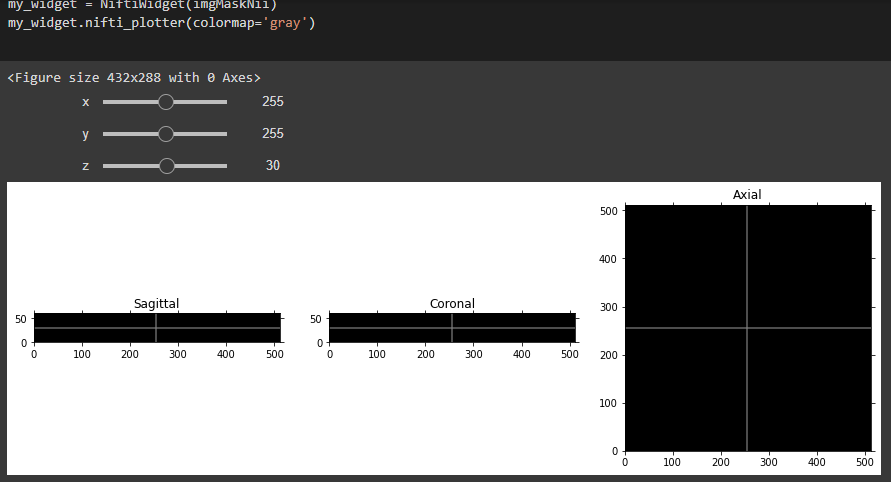

In [ ]:
from IPython.display import Image
Image(filename='MaskNii.PNG')


## Final 3d Prediction

In [ ]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

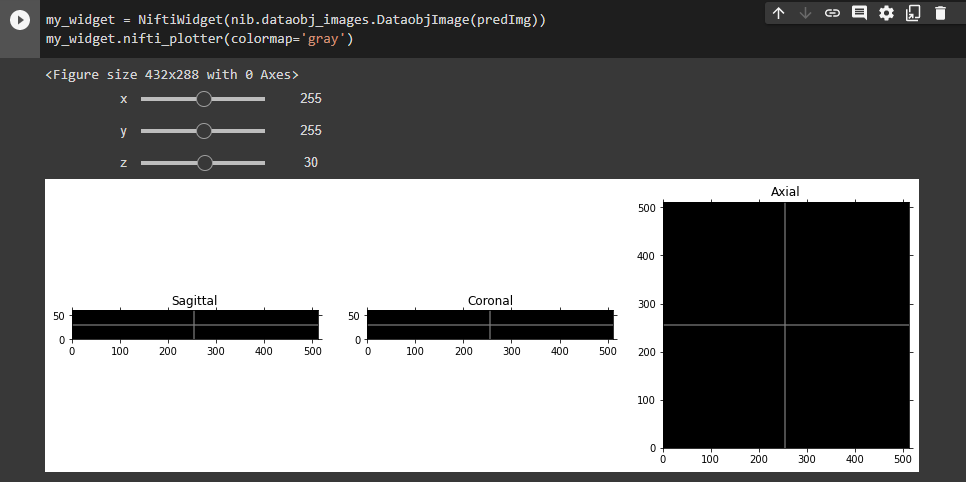

In [ ]:
from IPython.display import Image
Image(filename='Predict.PNG')


**Important Points:**

1. The data is visualized using **niBabel and niwidgets** package.
2. **Inference** is done using the test data provided in the dataset (.tarfile).
3. The model that, we've used is pre-trained on the ImageNet dataset and then, got trained on our colon cancer medical dataset. So, this means the **Transfer Learning is Utilized**.
4. The latency is also **less than 250 ms**.
5. Firstly, predicted the performance on the **2D data**.
6. Secondly, predicted the performance on the **3D data** using a custom function.